In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import layers

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

# CLEAN UP MEMORY
gc.collect()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


22

In [2]:
#READ DATA FROM FILE
dataset=pd.read_csv("C:/ProgramData/ETH/TrainingData/training.csv", sep=',',header=0)
#PRINT DATA
print(dataset)

             close        date         high          low         open  \
0       454.914024  1604880000   455.544267   454.056224   454.097939   
1       453.433040  1604880300   454.678762   453.038198   454.678762   
2       452.669440  1604880600   454.500000   452.669440   453.671881   
3       451.535630  1604880900   453.007440   451.132360   452.499455   
4       452.634457  1604881200   453.000000   451.939406   451.939406   
...            ...         ...          ...          ...          ...   
43065  2072.103614  1617778800  2089.056150  2071.007976  2088.562283   
43066  2072.088014  1617779100  2075.983447  2065.557520  2072.103614   
43067  2077.117034  1617779400  2077.875883  2072.175936  2073.086013   
43068  2072.138063  1617779700  2077.886044  2069.025950  2077.207710   
43069  2076.864882  1617780000  2076.864882  2071.103559  2072.761413   

       quoteVolume         volume  weightedAverage  
0         5.931550    2695.082042       454.363902  
1        31.18813

In [3]:
#CONDUCT PEARSON CORRELATION
correlation_matrix = dataset.corr()
print(correlation_matrix)

                    close      date      high       low      open  \
close            1.000000  0.946695  0.999981  0.999979  0.999963   
date             0.946695  1.000000  0.946588  0.946822  0.946687   
high             0.999981  0.946588  1.000000  0.999963  0.999981   
low              0.999979  0.946822  0.999963  1.000000  0.999976   
open             0.999963  0.946687  0.999981  0.999976  1.000000   
quoteVolume      0.026433 -0.009313  0.029006  0.023458  0.026770   
volume           0.253403  0.196249  0.255916  0.250493  0.253709   
weightedAverage  0.999989  0.946708  0.999989  0.999989  0.999983   

                 quoteVolume    volume  weightedAverage  
close               0.026433  0.253403         0.999989  
date               -0.009313  0.196249         0.946708  
high                0.029006  0.255916         0.999989  
low                 0.023458  0.250493         0.999989  
open                0.026770  0.253709         0.999983  
quoteVolume         1.000000  

<AxesSubplot:>

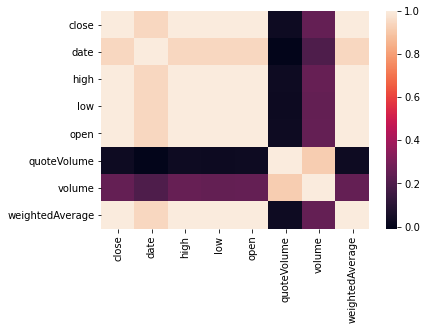

In [4]:
# plot the heatmap
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

In [5]:
#SELECT FEATURES AND TARGET
data = dataset[["high","low","open","weightedAverage", "close"]]
print(data)

              high          low         open  weightedAverage        close
0       455.544267   454.056224   454.097939       454.363902   454.914024
1       454.678762   453.038198   454.678762       453.824655   453.433040
2       454.500000   452.669440   453.671881       453.522696   452.669440
3       453.007440   451.132360   452.499455       452.100379   451.535630
4       453.000000   451.939406   451.939406       452.714873   452.634457
...            ...          ...          ...              ...          ...
43065  2089.056150  2071.007976  2088.562283      2078.473465  2072.103614
43066  2075.983447  2065.557520  2072.103614      2070.322271  2072.088014
43067  2077.875883  2072.175936  2073.086013      2075.345956  2077.117034
43068  2077.886044  2069.025950  2077.207710      2073.124147  2072.138063
43069  2076.864882  2071.103559  2072.761413      2073.894453  2076.864882

[43070 rows x 5 columns]


In [6]:
#SCALE DATA 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [7]:
#DEFINE MODEL CREATION METHOD. ENABLES EASY HYPER PARAM TUNING
def build_model(inputs, neurons, activ_func, dropout, loss, optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    
    model = models.Sequential()
    model.add(layers.LSTM(neurons, return_sequences=False, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(units=inputs.shape[2]))
    #model.add(layers.Dense(units=1))
    model.add(layers.Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [8]:
def split_data(training_split, data):
    # split into train and test sets
    train_size = int(len(data) * training_split)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return (train, test)

In [9]:
def split_sequences_multivariate_output(sequences, look_back, look_forward):
    x, y = list(), list()
    for i in range(len(sequences)):
        # end index of lookback window
        lookback_end_index = i + look_back
        lookforward_end_index = i + look_back + look_forward
        # exit if we are beyond the dataset
        if lookforward_end_index > len(sequences)-1:
            break
        # gather input and output parts of the pattern. input is lookback window of data, output is next step of data
        seq_x, seq_y = sequences[i:lookback_end_index, :], sequences[lookback_end_index:lookforward_end_index, :]
        x.append(seq_x)
        y.append(seq_y)
            
    return np.array(x), np.array(y)

In [10]:
#INIT HYPER PARAMS
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 0.2
batch_size = 12
epochs = 200
#epochs = 1
training_split = 0.7
look_back = 20
look_forward = 1

In [11]:
#SPLIT DATA FOR TRAINING
train_data, test_data = split_data(training_split, data)

In [12]:
#SHAPE DATA FOR LSTM INPUT
x_train, y_train = split_sequences_multivariate_output(train_data, look_back, look_forward)
x_test, y_test = split_sequences_multivariate_output(test_data, look_back, look_forward)

#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (30127, 20, 5).
training targets shape == (30127, 1, 5).
testing features shape == (12901, 20, 5).
testing features shape == (12901, 1, 5).
X_TRAIN
[[[0.01129529 0.01174612 0.01098914 0.01106678 0.01139118]
  [0.01079006 0.0111495  0.0113287  0.01075192 0.01052513]
  [0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  ...
  [0.01157216 0.01289617 0.01211199 0.01203291 0.01203711]
  [0.01157241 0.01256473 0.01178137 0.01202523 0.01203736]
  [0.01184735 0.01275722 0.0123876  0.01227317 0.0119784 ]]

 [[0.01079006 0.0111495  0.0113287  0.01075192 0.01052513]
  [0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  [0.00981445 0.01003257 0.01005462 0.00974514 0.00941555]
  ...
  [0.01157241 0.01256473 0.01178137 0.01202523 0.01203736]
  [0.01184735 0.01275722 0.0123876  0.01227317 0.0119784 ]
  [0.01151345 0.01271817 0.01205319 0.01191385 0.0118595 ]]

 [[0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  [0.00981445 0.01003257 0.01005462 0.0097

In [13]:
#ONLY NEEDS TO HAPPEN IF LOOK FORWARD IS 1
#y_train =  np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
#y_test =  np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [14]:
#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (30127, 20, 5).
training targets shape == (30127, 1, 5).
testing features shape == (12901, 20, 5).
testing features shape == (12901, 1, 5).
X_TRAIN
[[[0.01129529 0.01174612 0.01098914 0.01106678 0.01139118]
  [0.01079006 0.0111495  0.0113287  0.01075192 0.01052513]
  [0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  ...
  [0.01157216 0.01289617 0.01211199 0.01203291 0.01203711]
  [0.01157241 0.01256473 0.01178137 0.01202523 0.01203736]
  [0.01184735 0.01275722 0.0123876  0.01227317 0.0119784 ]]

 [[0.01079006 0.0111495  0.0113287  0.01075192 0.01052513]
  [0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  [0.00981445 0.01003257 0.01005462 0.00974514 0.00941555]
  ...
  [0.01157241 0.01256473 0.01178137 0.01202523 0.01203736]
  [0.01184735 0.01275722 0.0123876  0.01227317 0.0119784 ]
  [0.01151345 0.01271817 0.01205319 0.01191385 0.0118595 ]]

 [[0.01068571 0.01093338 0.01074005 0.01057561 0.01007858]
  [0.00981445 0.01003257 0.01005462 0.0097

In [15]:
# CLEAN UP MEMORY
gc.collect()
# random seed for reproducibility
np.random.seed(404)
# initialise model architecture
model = build_model(x_train, neurons=neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer)
# train model on data
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test), shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1060864   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 1,063,429
Trainable params: 1,063,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2511/2511 [==============================] - 18s 6ms/step - loss: 7.2296e-05 - mae: 0.0053 - val_loss: 0.0162 - val_mae: 0.1107
Epoch 2/200
2511/2511 [==============================] - 15s 6ms/step - loss: 0.0012 - mae: 0.0124 - val

Epoch 53/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.2848e-05 - mae: 0.0049 - val_loss: 0.0050 - val_mae: 0.0631
Epoch 54/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.5527e-05 - mae: 0.0051 - val_loss: 0.0035 - val_mae: 0.0522
Epoch 55/200
2511/2511 [==============================] - 15s 6ms/step - loss: 3.9816e-05 - mae: 0.0047 - val_loss: 0.0035 - val_mae: 0.0521
Epoch 56/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.1787e-05 - mae: 0.0048 - val_loss: 0.0035 - val_mae: 0.0522
Epoch 57/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.3721e-05 - mae: 0.0049 - val_loss: 0.0036 - val_mae: 0.0527
Epoch 58/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.3380e-05 - mae: 0.0049 - val_loss: 0.0037 - val_mae: 0.0536
Epoch 59/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.4778e-05 - mae: 0.0050 - val_loss: 0.0036 - val_mae: 0.0531
Epoch 60/200


2511/2511 [==============================] - 15s 6ms/step - loss: 3.4371e-05 - mae: 0.0043 - val_loss: 0.0026 - val_mae: 0.0459
Epoch 112/200
2511/2511 [==============================] - 16s 6ms/step - loss: 4.8546e-05 - mae: 0.0049 - val_loss: 0.0027 - val_mae: 0.0468
Epoch 113/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.7799e-05 - mae: 0.0048 - val_loss: 0.0030 - val_mae: 0.0488
Epoch 114/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.8329e-05 - mae: 0.0049 - val_loss: 0.0028 - val_mae: 0.0473
Epoch 115/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.7016e-05 - mae: 0.0048 - val_loss: 0.0031 - val_mae: 0.0494
Epoch 116/200
2511/2511 [==============================] - 15s 6ms/step - loss: 5.0963e-05 - mae: 0.0049 - val_loss: 0.0031 - val_mae: 0.0502
Epoch 117/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.7270e-05 - mae: 0.0049 - val_loss: 0.0030 - val_mae: 0.0488
Epoch 118/200
2511/2

Epoch 169/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.5190e-05 - mae: 0.0048 - val_loss: 0.0024 - val_mae: 0.0449
Epoch 170/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.5497e-05 - mae: 0.0048 - val_loss: 0.0026 - val_mae: 0.0461
Epoch 171/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.5818e-05 - mae: 0.0048 - val_loss: 0.0025 - val_mae: 0.0459
Epoch 172/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.5222e-05 - mae: 0.0047 - val_loss: 0.0026 - val_mae: 0.0465
Epoch 173/200
2511/2511 [==============================] - 15s 6ms/step - loss: 4.4961e-05 - mae: 0.0047 - val_loss: 0.0037 - val_mae: 0.0558
Epoch 174/200
2511/2511 [==============================] - 15s 6ms/step - loss: 5.0614e-05 - mae: 0.0050 - val_loss: 0.0018 - val_mae: 0.0389
Epoch 175/200
2511/2511 [==============================] - 15s 6ms/step - loss: 3.3560e-05 - mae: 0.0043 - val_loss: 0.0025 - val_mae: 0.0463
Epoch 

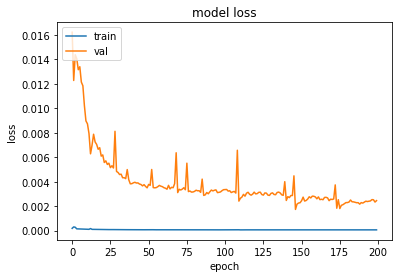

In [17]:
#PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

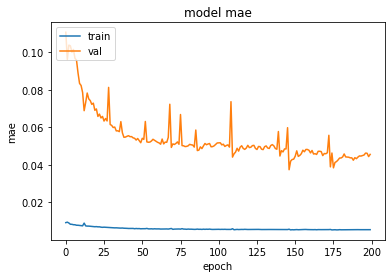

In [18]:
#PLOT LOSS
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
#PERFORM PREDICTIONS
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict.shape)
print(test_predict.shape)

(30127, 5)
(12901, 5)


In [20]:
test_predict_shaped = scaler.inverse_transform(np.array(test_predict))
train_predict_shaped = scaler.inverse_transform(np.array(train_predict))
test_predict_shaped = test_predict_shaped[:,4:5]
train_predict_shaped = train_predict_shaped[:,4:5]
print(test_predict_shaped.shape)
print(train_predict_shaped.shape)

(12901, 1)
(30127, 1)


In [21]:
train_mse = mean_squared_error(y_train[:,0,4], train_predict[:,4])
test_mse = mean_squared_error(y_test[:,0,4], test_predict[:,4])
# calculate mean squared error
print('Train Score: %.2f RMSE' % (train_mse))
print('Test Score: %.2f RMSE' % (test_mse))

# calculate root mean squared error
print('Train Score: %.2f RMSE' % (math.sqrt(train_mse)))
print('Test Score: %.2f RMSE' % (math.sqrt(test_mse)))

# calculate root mean abs error
print('Train Score: %.2f MAE' % (mean_absolute_error(y_train[:,0,4], train_predict[:,4])))
print('Test Score: %.2f MAE' % (mean_absolute_error(y_test[:,0,4], test_predict[:,4])))

# calculate root mean squared error
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0,4], train_predict[:,4])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(y_test[:,0,4], test_predict[:,4])))

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE
Train Score: 0.05 MAE
Test Score: 0.05 MAE
Train Score: 4763803804.88 MAPE
Test Score: 0.06 MAPE


In [22]:

baseData = scaler.inverse_transform(data)[:, 4:5]
# initialize to length of base data
trainPredictPlot = np.empty_like(baseData)
# set all elements to nan
trainPredictPlot[:, :] = np.nan
# shift train predictions by window length for plotting
trainPredictPlot[look_back:len(train_predict_shaped)+look_back, :] = train_predict_shaped
# initialize to length of base data
testPredictPlot = np.empty_like(baseData)
#set all elements to nan
testPredictPlot[:, :] = np.nan
#shift by length of training predictions plus 
testPredictPlot[len(train_predict_shaped)+(look_back*2)+1:len(baseData)-1, :] = test_predict_shaped[0:12764, :]
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseData, '-', color='k', label='Close')
plt.plot(trainPredictPlot, '-', color='g', label='Train Predicted Close')
plt.plot(testPredictPlot, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()

ValueError: could not broadcast input array from shape (12764,1) into shape (12901,1)

In [ ]:
baseTestData = scaler.inverse_transform(test_data)[:, 4:5]
testPredictPlot2 = np.empty_like(baseTestData)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[look_back:len(train_predict_shaped)+look_back, :] = test_predict_shaped
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseTestData, '-', color='k', label='Close')
plt.plot(testPredictPlot2, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()

In [ ]:
model_json = model.to_json()

with open("C:\ProgramData\ETH\Model\model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("C:\ProgramData\ETH\Model\model.h5")